In [264]:
#importing libraries
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

import statsmodels.api as sm
from statsmodels.formula.api import ols

import math

#importing file from csv
mkt = pd.read_csv(r"C:\Users\pedro\Desktop\Ironhack\lab-customer-analysis-round-7\files_for_lab\csv_files\marketing_customer_analysis.csv")
print(mkt.shape)

(9134, 24)


In [265]:
#function standardizing headers names

def standard_headers(df):
    #standardizing headers names
    cols = []
    for i in range(len(df.columns)):
        cols.append(df.columns[i].lower().replace(' ','_'))
    df.columns = cols   
    return df

In [266]:
#applying the function
mkt=standard_headers(mkt)

In [267]:
#defining function counting NAs and percentage of NAs by variable

def check_NA(df):
    print(df.isna().sum().sum())
    print("\n",df.isna().sum() / len(df))

In [268]:
check_NA(mkt)

0

 customer                         0.0
state                            0.0
customer_lifetime_value          0.0
response                         0.0
coverage                         0.0
education                        0.0
effective_to_date                0.0
employmentstatus                 0.0
gender                           0.0
income                           0.0
location_code                    0.0
marital_status                   0.0
monthly_premium_auto             0.0
months_since_last_claim          0.0
months_since_policy_inception    0.0
number_of_open_complaints        0.0
number_of_policies               0.0
policy_type                      0.0
policy                           0.0
renew_offer_type                 0.0
sales_channel                    0.0
total_claim_amount               0.0
vehicle_class                    0.0
vehicle_size                     0.0
dtype: float64


In [269]:
#creating dataframes for numerical and categorical variables
numerical = mkt.select_dtypes(include=[np.number])
categoricals = mkt.select_dtypes(['object'])

In [270]:
#functions to display correlations above a treshold

def correlations (df,treshold):
    correlations_matrix = df.corr()
    correlated_variables = correlations_matrix[abs(correlations_matrix) >= treshold]
    correlated_variables = correlated_variables.mask(np.tril(np.ones(correlated_variables.shape)).astype(bool)) 
    correlated_variables_pairs = [(col1,col2) for col1 in correlated_variables.columns for col2 in correlated_variables.columns if not pd.isna(correlated_variables[col1][col2])]
    print("variables correlated above",treshold,"are: \n\n",correlated_variables_pairs)
    print("\n\n variables correlated above",treshold,"with 'total claim amount' are: \n\n", pd.DataFrame([k for k in correlated_variables_pairs if 'total_claim_amount' in k])[1])

In [271]:
correlations(numerical,0.5)

variables correlated above 0.5 are: 

 [('total_claim_amount', 'monthly_premium_auto')]


 variables correlated above 0.5 with 'total claim amount' are: 

 0    monthly_premium_auto
Name: 1, dtype: object


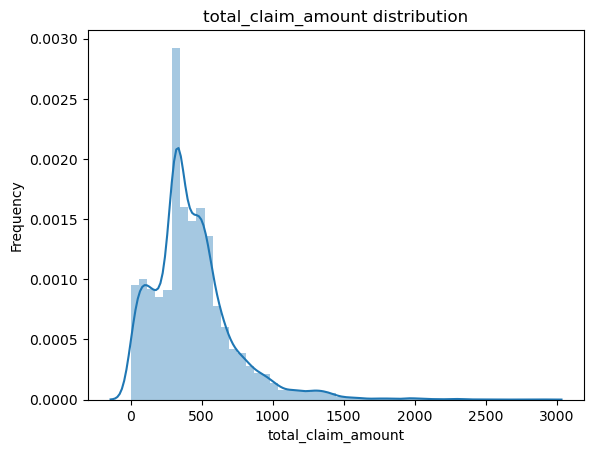

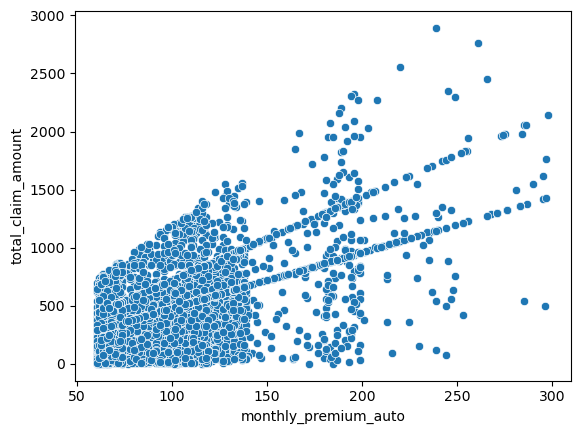

In [272]:
#histogram of total_claim_amount
sns.distplot(mkt['total_claim_amount'])
plt.xlabel('total_claim_amount')
plt.ylabel('Frequency')
plt.title('total_claim_amount distribution')
plt.show()

sns.scatterplot(x=mkt['monthly_premium_auto'], y=mkt['total_claim_amount'])
plt.show()

In [273]:
import plotly.express as px

px.box(mkt['total_claim_amount'])

In [274]:
#function to find outliers

def find_outliers_IQR(df,column_name):
    q1=df[column_name].quantile(0.25)
    q3=df[column_name].quantile(0.75)
    IQR=q3-q1
    outliers = df[column_name][((df[column_name]<(q1-1.5*IQR)) | (df[column_name]>(q3+1.5*IQR)))]
    return outliers

In [275]:
#function to find extreme outliers

def find_extreme_outliers_IQR(df,column_name):
    q1=df[column_name].quantile(0.25)
    q3=df[column_name].quantile(0.75)
    IQR=q3-q1
    outliers = df[column_name][((df[column_name]<(q1-3*IQR)) | (df[column_name]>(q3+3*IQR)))]
    return outliers

In [276]:
#applying the function
#displaying the number of extreme outliers

outliers = find_extreme_outliers_IQR(mkt,'total_claim_amount')
print("number of extreme outliers: "+ str(len(outliers)))
print("max outlier value: "+ str(outliers.max()))
print("min outlier value: "+ str(outliers.min()))

number of extreme outliers: 115
max outlier value: 2893.239678
min outlier value: 1375.2


In [277]:
#function to drop extreme outliers

def drop_extreme_outliers_IQR(df,column_name):
    q1=df[column_name].quantile(0.25)
    q3=df[column_name].quantile(0.75)
    IQR=q3-q1
    not_outliers = df[~((df[column_name]<(q1-3*IQR)) | (df[column_name]>(q3+3*IQR)))]
    return not_outliers

In [278]:
#dropping extreme outliers

mkt=drop_extreme_outliers_IQR(mkt,'total_claim_amount')
print(mkt.shape)

(9019, 24)


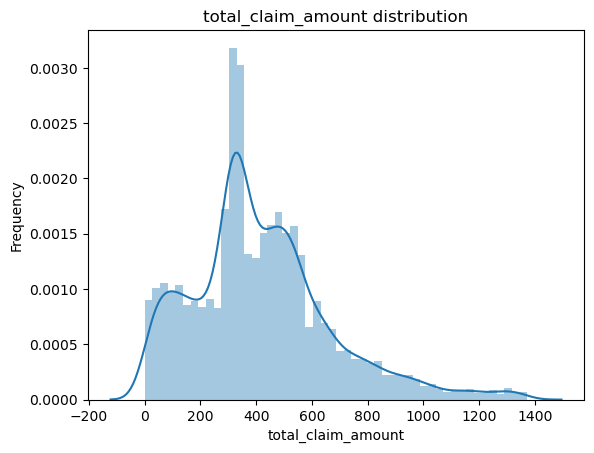

In [279]:
#histogram of total_claim_amount

sns.distplot(mkt['total_claim_amount'])
plt.xlabel('total_claim_amount')
plt.ylabel('Frequency')
plt.title('total_claim_amount distribution')
plt.show()

In [280]:
#splitting into numerical and categorical dataframes

numerical = mkt.select_dtypes(include=[np.number])
categoricals = mkt.select_dtypes(['object'])
print(numerical.shape)
print(categoricals.shape)

(9019, 8)
(9019, 16)


In [281]:
#normalizing data
#encoding categorical data

def normalization(df_num,df_cat):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(df_num)
    normalized_data = pd.DataFrame(normalized_data, columns=df_num.columns)
    #Encoding Categorical Data
    dummy_data = pd.get_dummies(df_cat.drop(['customer','effective_to_date'], axis=1), drop_first=True).reset_index()
    #Concatenating DataFrames
    df_data = pd.concat([normalized_data,dummy_data],axis=1)
    return df_data

In [282]:
#applying function
mkt_data=normalization(numerical,categoricals)

In [283]:
#Splitting into train set and test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mkt_data.drop(['total_claim_amount'], axis=1),mkt_data['total_claim_amount'],test_size=0.2)

Y = y_train
X = X_train
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

ypred=round(model.predict(X),2)
r2=round(r2_score(Y,ypred),3)
mse=round(mean_squared_error(Y,ypred),3)
rmse=round(math.sqrt(mean_squared_error(Y,ypred)),3)
mae=round(mean_absolute_error(Y,ypred),3)
print("R2:",r2,"MSE:",mse,"RMSE:",rmse,"MAE:",mae)  

R2: 0.784 MSE: 0.007 RMSE: 0.086 MAE: 0.063


In [284]:
#let's check which variables should we drop
#identifying which variables are not significant (p-values under 0.05)

pvalues = pd.DataFrame(model.pvalues)
pvalues['variable']=pvalues.index

pvalues.columns = ['pvalue', 'variable']

#filtering only significant variables
pvalues_sig=pvalues[pvalues['pvalue']<0.05]
pvalues_sig

X_sig=X.filter(items=pvalues_sig['variable'])

#removing non-significant variables and running the new model
#reduction from 50 to 16 variables
#R2, MSE and MAE remained almost unchanged so the quality of the model remains and the number of variables decreased a lot

X_sig = sm.add_constant(X_sig)
model = sm.OLS(Y,X_sig).fit()

ypred=round(model.predict(X_sig),2)
r2=round(r2_score(Y,ypred),3)
mse=round(mean_squared_error(Y,ypred),3)
rmse=round(math.sqrt(mean_squared_error(Y,ypred)),3)
mae=round(mean_absolute_error(Y,ypred),3)

print("The linear regression model coefficients are: \n\n", model.params)
print("\n\n Model Validation: R2:",r2,"MSE:",mse,"RMSE:",rmse,"MAE:",mae) 

The linear regression model coefficients are: 

 const                            -0.014184
income                           -0.019245
monthly_premium_auto              0.748478
response_Yes                     -0.014719
education_College                -0.003008
education_High School or Below    0.007711
employmentstatus_Unemployed       0.040172
gender_M                          0.006744
location_code_Suburban            0.274413
location_code_Urban               0.156476
marital_status_Single             0.045176
policy_type_Special Auto          0.006107
policy_Special L1                 0.027291
renew_offer_type_Offer2           0.008820
renew_offer_type_Offer3           0.004193
dtype: float64


 Model Validation: R2: 0.782 MSE: 0.007 RMSE: 0.087 MAE: 0.063
